## Preprocessing of imaging data: Volume vs. projection to single plane

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume
import fly2p.preproc.imgPreproc as imp

### (1) Load, parse metadata and generate data object
#### Set paths to data files and plot directory

In [38]:
rootDir = '../../../../data_unityvr'
subdir = 'Drep2test'
dataDir = sep.join([rootDir, 'raw',subdir,'56H10_x_6fDrep2/BU/f01'])
rawTiff = '56H10_x_6fDrep2_f01_BU_panA2_00001.tif'
plotDir = sep.join([rootDir, 'plot', sep.join(dataDir.split(sep)[-4:])])
preprocDir = sep.join([rootDir, 'preproc', sep.join(dataDir.split(sep)[-4:])])

genotype = '-'.join(rawTiff.split('_')[0:3])
[flyID, region] = rawTiff.split('_')[3:5]
condition = 'panTest'#rawTiff.split('_')[-2]
trial = "trial"+rawTiff.split('_')[-1][3:-4]
print('Genotype: {}, Imaging region: {}, Fly id: {}\nCondition: {}, Trial: {}'.format(
    genotype, region, flyID, condition, trial))

Genotype: 56H10-x-6fDrep2, Imaging region: BU, Fly id: f01
Condition: panTest, Trial: trial01


In [40]:
# Generate directory where to save plots
saveDir = sep.join([plotDir]) #condition
if not exists(saveDir):
    makedirs(saveDir)
print(saveDir)

ppsaveDir = sep.join([preprocDir])
if not exists(ppsaveDir):
    makedirs(ppsaveDir)
print(ppsaveDir)

../../../../data_unityvr/plot/Drep2test/56H10_x_6fDrep2/BU/f01
../../../../data_unityvr/preproc/Drep2test/56H10_x_6fDrep2/BU/f01


#### Load data and perform motion correction
Extract relevant information from header

In [5]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


Read and reshape image tiff stack

In [6]:
stack = loadvolume(mytiffreader, basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

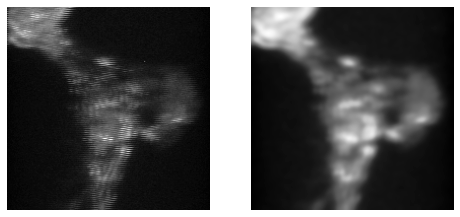

In [7]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 600
locRefImg = round(stackMP['volumes [s]'].size/3)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

In [8]:
# try larger sigma (last function argument) for BU imaging
stackMPMC, shift = imp.motionCorrection(stackMP, refImg, 20, 2)

In [11]:
#viewerMPMC = napari.view_image(stackMPMC)

Apply estimated motion to 4d stack. We assume here that all planes in a volume at a given time moved together

In [9]:
stack4dMC = imp.applyShiftTo4Dstack(imgStack, shift)

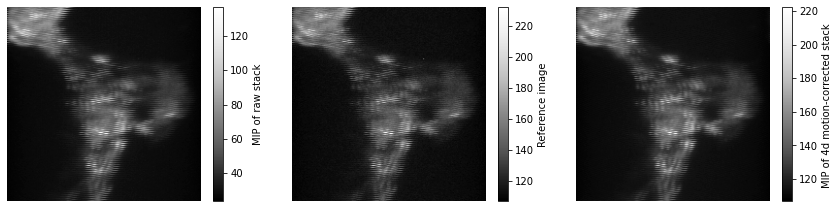

In [10]:
fig, axs = plt.subplots(1,3,figsize=(12,3))
cb = axs[0].imshow(stack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

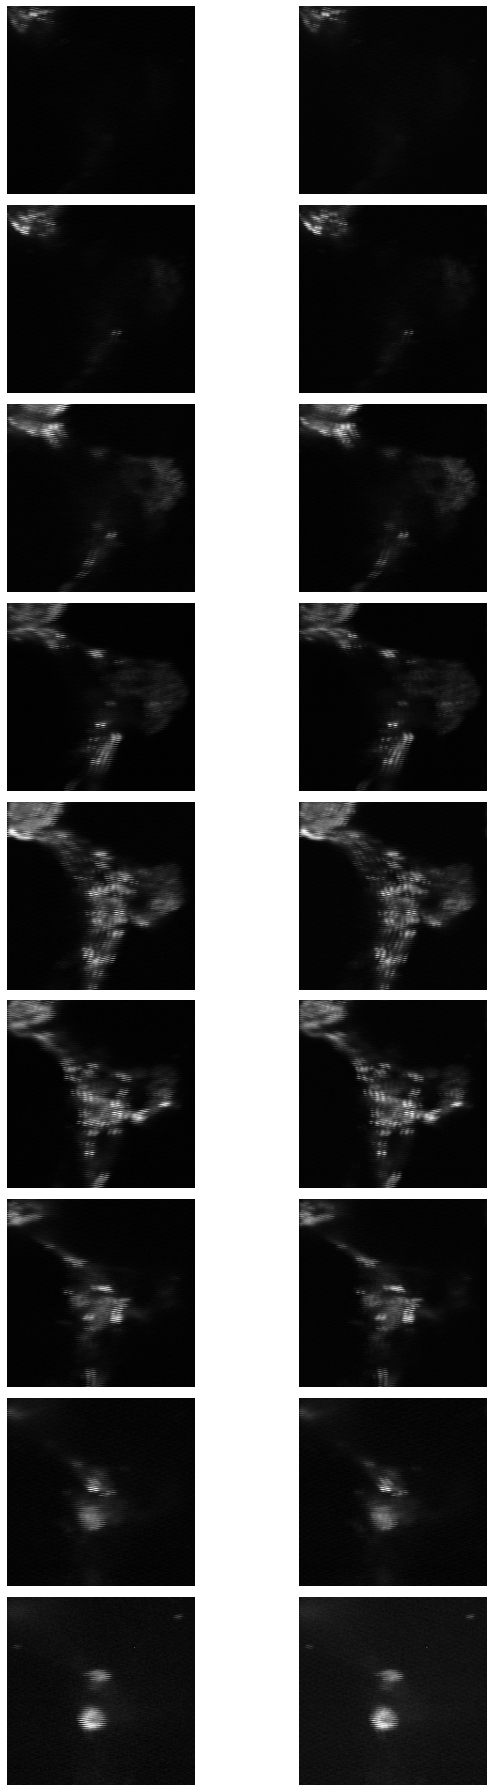

In [11]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2, figsize=(10, 25))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i,0].imshow(imgStack[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,1].imshow(stack4dMC[:,i,:,:].mean(axis=0),cmap='Greys_r',origin='lower')
    ax[i,0].axis('off')
    ax[i,1].axis('off');
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['meanSignal_beforeAfterMC_',genotype, region, flyID, condition, trial])+'.pdf')

### Perform correlation analysis to get ROIs

#### (1) Compute DFF

In [12]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

(a) one plane

In [13]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

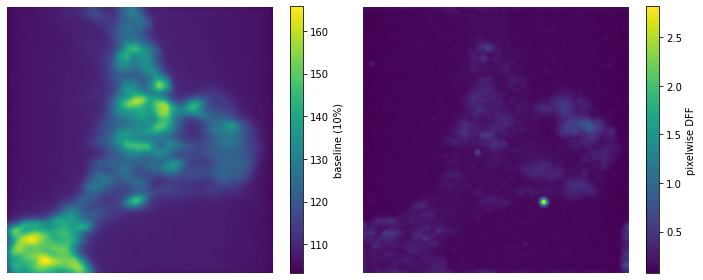

In [14]:
dffMP = np.max(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)
fig.savefig(saveDir+sep+'_'.join(['BaselineAndDFF_MIP',genotype, region, flyID, condition, trial])+'.pdf')

(b) volume

In [15]:
dffStack4dMC = np.zeros((stack4dMC.shape)) 
stackF0vol = np.zeros((stack4dMC["planes [µm]"].size, stackMPMC["xpix [µm]"].size, stackMPMC["ypix [µm]"].size)) 

from scipy.signal import savgol_filter

for p in range(stack4dMC["planes [µm]"].size):
    filtStack = gaussian_filter(stack4dMC[{'planes [µm]': p}].squeeze(), sigma=[0,2,2])

    filtF = savgol_filter(filtStack.astype('float'), window, order, axis=0)

    # Estimate baseline
    stackF0vol[p,:,:] = np.percentile(filtF, baseLinePercent, axis=0) + offset
    stackF0vol[p,np.where(stackF0vol[p,:,:] == 0)[0]] += offset

    # Compute dF/F_0 = (F_raw - F_0)/F_0
    dffStack4dMC[:,p,:,:] = (filtF - stackF0vol[p,:,:]) / stackF0vol[p,:,:]

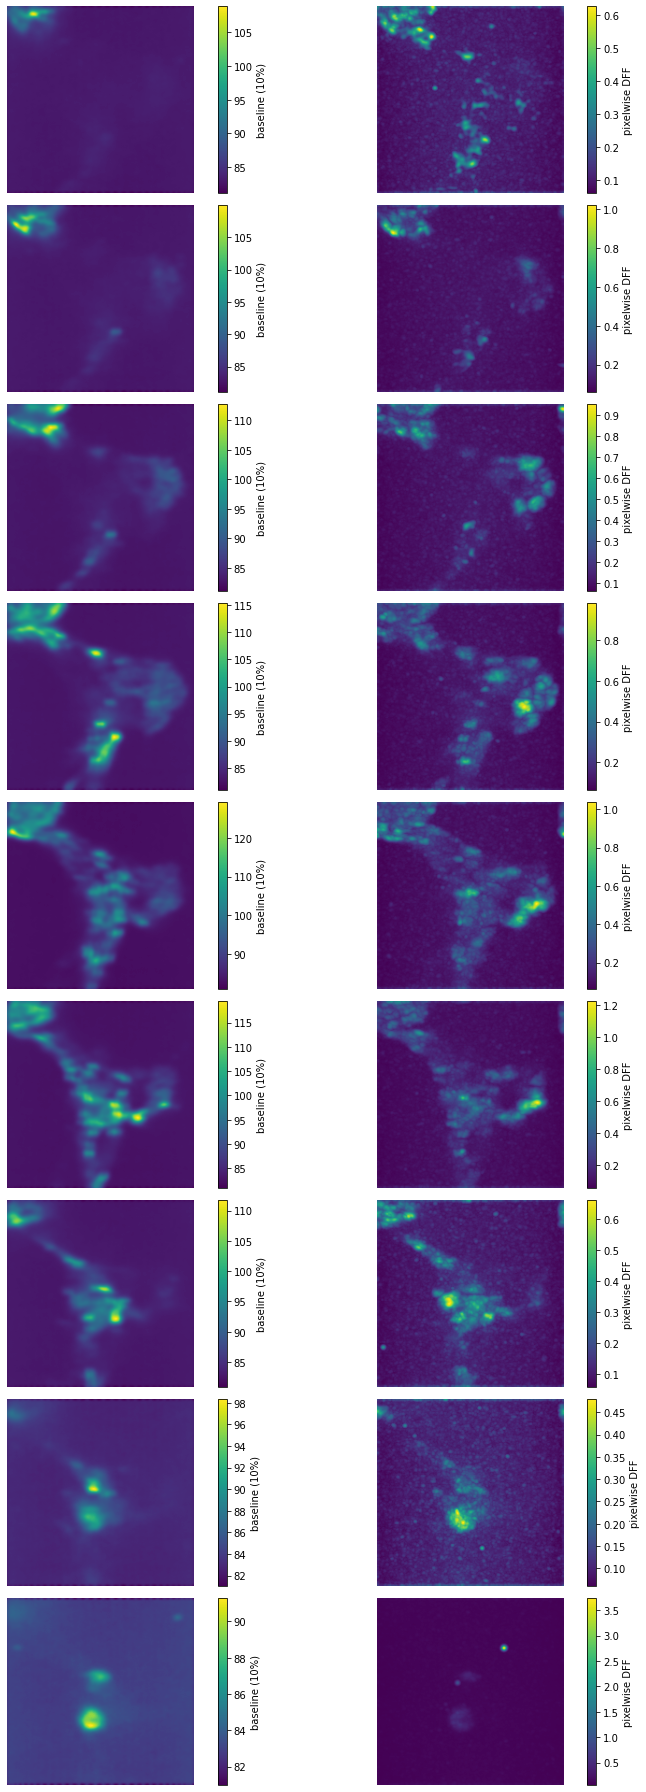

In [16]:
fig, ax = plt.subplots(stack4dMC["planes [µm]"].size,2,figsize=(12,25))
for i in range(stack4dMC["planes [µm]"].size):
    cb = ax[i,0].imshow(stackF0vol[i,:,:],cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,0], label='baseline ({}%)'.format(baseLinePercent))
    ax[i,0].axis('off')
    
    cb = ax[i,1].imshow(np.max(dffStack4dMC[:,i,:,:],axis=0),cmap='viridis',origin='lower')#, vmin=0, vmax=10)
    plt.colorbar(cb, ax=ax[i,1], label='pixelwise DFF')
    ax[i,1].axis('off')
    
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['DFFperPlane_beforeAfterMC_',genotype, region, flyID, condition, trial])+'.pdf')

In [17]:
#viewerdff1 = napari.view_image(dffStack4dMC)

#### (2) Define regions on which to perform clustering
Mark the area that should be considered with the napari labeling tool in a layer named "mask".

(a) Single plane mask for max projection

In [19]:
viewer = napari.view_image(refImgFilt)

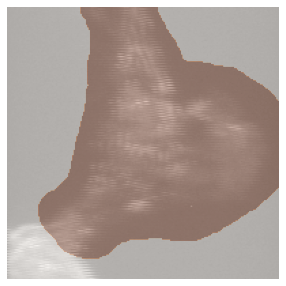

In [20]:
# you can draw a mask:
mask = viewer.layers["mask"]
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r', vmin=0, origin='lower')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.3)
fig.savefig(saveDir+sep+'_'.join(['mask',genotype, region, flyID, condition, trial])+'.pdf')

(b) 3D mask for volume processing

In [21]:
refStack = stack4dMC[0,:,:,:]
for i in range(stack4dMC["planes [µm]"].size):
    refStack[i,:,:] = stack4dMC[:,i,:,:].mean(axis=0)
    
viewer3D = napari.view_image(refStack)

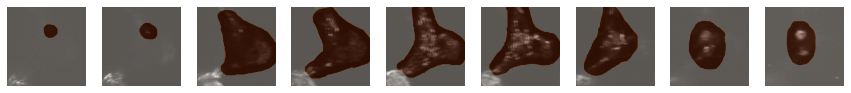

In [22]:
mask3D = viewer3D.layers["mask"]

fig, ax = plt.subplots(1,stack4dMC["planes [µm]"].size, figsize=(15,4))
for i in range(stack4dMC["planes [µm]"].size):
    ax[i].imshow(refStack[i,:,:],cmap='Greys_r',origin='lower')  
    ax[i].axis('off');
    ax[i].imshow(mask3D.data[i,:,:], cmap='Oranges', alpha=0.35)
    
fig.savefig(saveDir+sep+'_'.join(['mask3D',genotype, region, flyID, condition, trial])+'.pdf')

#### (3) Perform clustering on pixels in mask

TODO: Check time axis generatiton

In [23]:
# Settings
from sklearn.cluster import KMeans

nclst = 6 # 4 for FBt

One plane

In [24]:
dffMask = np.logical_and(mask.data>0, np.std(dffStack, axis=0) > 0.03)
toClust = dffStack[:,dffMask]

kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

KMeans(n_clusters=6)

In [25]:
kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [26]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

kmlabsImg = np.nan*np.ones(dffMask.shape)

kmlabsImg[dffMask] = kmlabs

ypos = np.repeat(np.arange(dffMask.shape[0]),dffMask.shape[1]).reshape(dffMask.shape)
yPosClust = np.zeros(nclst)
for i in range(nclst):
    yPosClust[i] = dffMask.shape[0]-np.median(ypos[kmlabsImg==i])
    
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids[centroidPerm,:]

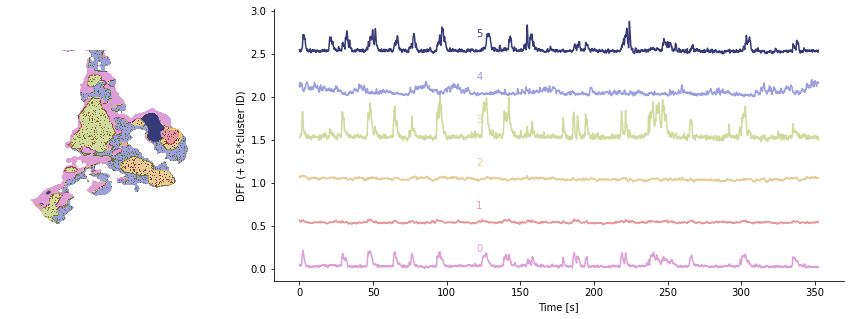

In [27]:
fig, axs = plt.subplots(1,2,figsize=(15,5), gridspec_kw={'width_ratios':[1,3]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids2Plot[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    axs[1].text(120,i*0.5+.2,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])

fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

<ipython-input-28-b42b32b9db70>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')


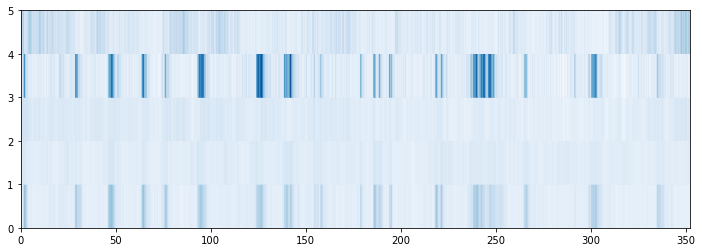

In [28]:
fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster_kn{}_DFFreordered'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

Volume

In [ ]:
nclst_4d = 10

dffMask = np.logical_and(mask3D.data>0, np.std(dffStack4dMC, axis=0) > 0.03)
toClust = dffStack4dMC[:,dffMask]

kmeans_4d = KMeans(n_clusters=nclst_4d)
kmeans_4d.fit(toClust.T)

In [ ]:
kmlabs_4d = kmeans_4d.predict(toClust.T)
centroids_4d = kmeans_4d.cluster_centers_

In [ ]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst_4d)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

#time = np.linspace(0, stackMPMC.shape[0]/basicMetadat['fpv'], stackMPMC.shape[0])

In [ ]:
kmlabsImg_3d = np.nan*np.ones(mask3D.data.shape)

kmlabsImg_3d[dffMask] = kmlabs_4d

fig = plt.figure(constrained_layout=True,figsize=(15,10))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(2,stack4dMC["planes [µm]"].size)

for p in range(stack4dMC["planes [µm]"].size):
    ax = fig.add_subplot(gs[0,p])
    ax.imshow(kmlabsImg_3d[p,:,:],cmap=myClstMap,origin='upper',vmin=0, vmax=nclst_4d)
    ax.axis('off')

ax = fig.add_subplot(gs[1,:])
for i in range(nclst_4d):
    ax.plot(time,centroids_4d[i]+i, color=clstCMap.to_rgba(i+1))
    ax.text(120,+i+.5,str(i),color=clstCMap.to_rgba(i+1))
ax.set_xlabel('Time [s]')
ax.set_ylabel('DFF (+ 0.5*cluster ID)')
#ax.set_ylim(0, 1+nclst_4d)
myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

In [ ]:
kmlabsImg_3d = np.nan*np.ones(mask3D.data.shape)

kmlabsImg_3d[dffMask] = kmlabs_4d

fig = plt.figure(constrained_layout=True,figsize=(15,15))
#import matplotlib.gridspec as gridspec
gs  = fig.add_gridspec(nclst_4d,stack4dMC["planes [µm]"].size)

for k in range(nclst_4d):
    for p in range(stack4dMC["planes [µm]"].size):
        ax = fig.add_subplot(gs[k,p])
        myclustmap = (kmlabsImg_3d[p,:,:] == k).astype('float')
        myclustmap[myclustmap == 0] = np.nan
        ax.imshow(myclustmap*k,origin='upper',cmap=myClstMap, vmin=0, vmax=nclst_4d)
        if p==0: ax.set_ylabel('roi{}'.format(k))
        #ax.axis('off')
        myAxisTheme(ax)
fig.tight_layout()
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3DMap_kn{}'.format(nclst),genotype, region, flyID, condition, trial])+'.pdf')

In [ ]:
centroidPerm = np.argsort(yPosClust)#
centroids2Plot = centroids_4d#[centroidPerm,:]

fig, axs = plt.subplots(1,1,figsize=(12,4))

axs.pcolor(time,np.arange(0,nclst_4d),centroids2Plot,cmap='Blues', edgecolors='face')
fig.savefig(saveDir+sep+'_'.join(['ROIcluster3D_kn{}_DFFreordered'.format(nclst_4d),genotype, region, flyID, condition,  trial])+'.pdf')

#### Generate data object and save to disk

In [84]:
backgroundROI = 1
otherROIs = list(range(0,nclst))
otherROIs.remove(backgroundROI)

roiDf = pd.DataFrame(data = centroids[otherROIs].T, columns = ['roi{}'.format(i) for i in range(len(otherROIs))])
roiDf['background'] = centroids[backgroundROI].T
roiDf['time [s]'] = time
roiDf.head()

expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    refStackMC = np.mean(stackMPMC,axis=0), 
    dffMIP = np.max(dffXarray,axis=0), 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = kmlabsImg, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(ppsaveDir, trial)

ValueError: Shape of passed values is (3523, 10), indices imply (3523, 9)